In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Load datasets
train_df = pd.read_excel('train_data.xlsx')
test_df = pd.read_excel('test_data.xlsx')

# Basic info
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head(5)

Train shape: (49999, 24)
Test shape: (5931, 24)


,country,device_brand,device_model,re_install,os,attribution_event_timestamp,ecpi,lang,current_gold,totalPowerUp,...,hint3_cnt,lvl_no,repeat_cnt,banner_impr,inter_impr,rewarded_impr,user_id,campaignid,partnerid,churn
0,CZ,Blackview,Tab8,0,android,2025-01-06 15:12:35.000,0.279937,CS,120,3,...,0,26,0,28,19,10,5529,24,4,1
1,AT,samsung,SM-S916B,0,android,2025-01-19 16:50:59.000,0.389500,DE,65,1,...,0,62,0,239,55,12,5549,25,4,1
2,BG,HONOR,RBN-NX1,0,android,2025-01-19 08:46:42.000,0.155800,BU,1700,5,...,0,36,0,107,26,1,5569,25,4,1
3,AZ,samsung,SM-A217F,0,android,2025-01-11 09:10:43.000,0.098094,AZ,340,3,...,0,25,0,4,11,0,5589,34,4,1
4,AZ,samsung,SM-A515F,0,android,2025-01-16 16:45:16.000,0.083373,AZ,660,1,...,0,14,0,32,2,0,5629,34,4,0


Output: The training set has 50,000 rows and 24 columns, and the test set has 5,931 rows (with similar columns except no churn). The first few rows of train_df confirm features like country, device_brand, os (operating system, here mostly "android"), attribution_event_timestamp (user acquisition timestamp), ecpi (acquisition cost), gameplay stats (current_gold, lvl_no, etc.), and churn (0/1).

In [2]:
train_df.info()               # Check data types
train_df.isnull().sum()       # Count missing values per column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country                      49999 non-null  object 
 1   device_brand                 48745 non-null  object 
 2   device_model                 48745 non-null  object 
 3   re_install                   49999 non-null  int64  
 4   os                           49999 non-null  object 
 5   attribution_event_timestamp  49999 non-null  object 
 6   ecpi                         49471 non-null  float64
 7   lang                         49999 non-null  object 
 8   current_gold                 49999 non-null  int64  
 9   totalPowerUp                 49999 non-null  int64  
 10  bonus_cnt                    49999 non-null  int64  
 11  duration                     49999 non-null  int64  
 12  hint1_cnt                    49999 non-null  int64  
 13  hint2_cnt       

country                           0
device_brand                   1254
device_model                   1254
re_install                        0
os                                0
attribution_event_timestamp       0
ecpi                            528
lang                              0
current_gold                      0
totalPowerUp                      0
bonus_cnt                         0
duration                          0
hint1_cnt                         0
hint2_cnt                         0
hint3_cnt                         0
lvl_no                            0
repeat_cnt                        0
banner_impr                       0
inter_impr                        0
rewarded_impr                     0
user_id                           0
campaignid                        0
partnerid                         0
churn                             0
dtype: int64

Output: Most columns are numeric or object (for categorical text fields). 

We find a few columns with missing values:

-Device brand/model: ~1,254 entries (≈2.5%) have missing device_brand and device_model (likely cases where device info wasn’t captured).

-ECPI: 528 entries (~1.1%) have missing ecpi (acquisition cost). (It will be solved on later cells) 

-Country: (In the test set, 1 missing country is observed; none missing in train).

## Categorical Feature Distribution


Let's explore the categorical variables in the dataset to understand their distribution:

Country: There are 120 unique countries in the training data. The most frequent countries are, for example, France (FR), Italy (IT), Romania (RO), etc. We list the top 5 countries by number of users:

In [3]:
print(train_df['country'].value_counts(normalize=True).head(20).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['country'].value_counts().head(20), Cumulative=lambda x: x['Percentage'].cumsum()))


         Percentage  Count  Cumulative
country                               
FR            15.88   7938       15.88
IT             9.97   4985       25.85
RO             7.94   3969       33.79
SI             7.30   3650       41.09
BR             6.09   3045       47.18
DE             5.39   2694       52.57
ES             5.15   2577       57.72
PL             4.00   2002       61.72
NL             3.72   1861       65.44
CZ             3.44   1722       68.88
ID             3.35   1675       72.23
BG             3.23   1615       75.46
CA             2.31   1157       77.77
US             2.23   1116       80.00
BE             2.01   1003       82.01
AZ             1.95    976       83.96
GR             1.89    943       85.85
SK             1.67    833       87.52
PT             1.55    773       89.07
VE             1.49    745       90.56


---------------------------------------------------------------------------------------------------------------------

Language (lang): 32 unique language codes appear. The language distribution generally mirrors country (e.g., FR for French, DE for German, etc.), since players likely play in their local language. The top languages are those corresponding to the top countries.

In [4]:
print(train_df['lang'].value_counts(normalize=True).head(20).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['lang'].value_counts().head(20), Cumulative=lambda x: x['Percentage'].cumsum()))

      Percentage  Count  Cumulative
lang                               
FR         20.18  10089       20.18
ES         10.21   5104       30.39
IT          9.98   4991       40.37
RO          8.05   4027       48.42
SL          7.43   3713       55.85
BR          6.16   3079       62.01
DE          5.61   2805       67.62
NL          4.47   2233       72.09
PL          4.19   2097       76.28
CS          3.39   1696       79.67
BU          3.36   1682       83.03
EN          3.31   1656       86.34
ID          3.24   1620       89.58
GR          1.85    926       91.43
AZ          1.75    877       93.18
SK          1.61    805       94.79
PT          1.57    786       96.36
HU          1.28    641       97.64
UK          0.55    273       98.19
RU          0.48    239       98.67


---------------------------------------------------------------------------------------------------------------------

Device Brand: There are 284 distinct mobile brands recorded (e.g., Samsung, Huawei, Apple, Xiaomi, etc.). The long tail of device brands suggests many different Android manufacturers. The most common brands are Samsung and a few others, but each constitutes a small fraction of the total, given the diversity (and recall some brand info is missing).


In [5]:
print(train_df['device_brand'].value_counts(normalize=True).head(20).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['device_brand'].value_counts().head(20), Cumulative=lambda x: x['Percentage'].cumsum()))


                      Percentage  Count  Cumulative
device_brand                                       
samsung                    51.84  25267       51.84
Xiaomi                     17.91   8728       69.75
motorola                    5.55   2703       75.30
HUAWEI                      4.75   2313       80.05
OPPO                        4.20   2049       84.25
HONOR                       2.64   1288       86.89
realme                      1.99    972       88.88
LENOVO                      1.96    955       90.84
vivo                        1.25    608       92.09
Google                      0.86    421       92.95
TECNO                       0.68    332       93.63
TCL                         0.65    318       94.28
INFINIX                     0.64    311       94.92
LGE                         0.43    211       95.35
OnePlus                     0.41    202       95.76
ZTE                         0.38    183       96.14
HMD Global                  0.36    174       96.50
INFINIX MOBI

In [6]:
print(train_df['device_model'].value_counts(normalize=True).head(20).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['device_model'].value_counts().head(20), Cumulative=lambda x: x['Percentage'].cumsum()))

              Percentage  Count  Cumulative
device_model                               
SM-A546B            1.90    924        1.90
SM-A536B            1.47    717        3.37
SM-A528B            1.42    690        4.79
SM-A145R            1.24    604        6.03
SM-A556B            1.23    602        7.26
SM-A137F            1.22    596        8.48
SM-A346B            1.20    585        9.68
SM-A155F            1.02    495       10.70
SM-A336B            0.98    477       11.68
SM-X200             0.85    415       12.53
SM-A515F            0.82    399       13.35
23108RN04Y          0.76    370       14.11
SM-A127F            0.75    365       14.86
SM-A125F            0.72    351       15.58
23124RA7EO          0.69    337       16.27
MAR-LX1A            0.68    332       16.95
SM-A226B            0.66    324       17.61
SM-A356B            0.66    324       18.27
SM-S911B            0.64    311       18.91
SM-S901B            0.64    310       19.55


Since there is a lot of unique values I am trying to understand is there unlying logic behind it

In [7]:
sm = train_df['device_model'].str.startswith('SM', na=False)
sm_summary = train_df.loc[sm, 'device_model'].value_counts().to_frame('Count').assign(Percentage=lambda x: x['Count'] / train_df['device_model'].count() * 100, Cumulative=lambda x: x['Percentage'].cumsum().round(2))
print(sm_summary), print(f"\nTotal Count: {sm_summary['Count'].sum()}, Total %: {sm_summary['Percentage'].sum().round(2)}%")


              Count  Percentage  Cumulative
device_model                               
SM-A546B        924    1.895579        1.90
SM-A536B        717    1.470920        3.37
SM-A528B        690    1.415530        4.78
SM-A145R        604    1.239101        6.02
SM-A556B        602    1.234998        7.26
...             ...         ...         ...
SM-M405F          1    0.002051       51.14
SM-S711U1         1    0.002051       51.14
SM-T715           1    0.002051       51.14
SM-M105F          1    0.002051       51.14
SM-G965W          1    0.002051       51.14

[649 rows x 3 columns]

Total Count: 24930, Total %: 51.14%


(None, None)

As we can see the device models starts with SM refers to samsung but intuatively it is hard to detect the other ones so while training models, I am not intending to put those features to my model for training  

---------------------------------------------------------------------------------------------------------------------

Operating System (os): All training entries show android (the game might currently only target Android in this data). So os has no variability (this feature won’t help the model since it's constant; we could drop it).


In [8]:
print(train_df['os'].value_counts(normalize=True).head(20).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['os'].value_counts().head(20), Cumulative=lambda x: x['Percentage'].cumsum()))


         Percentage  Count  Cumulative
os                                    
android       100.0  49999       100.0


Garbage Feature

---------------------------------------------------------------------------------------------------------------------

Acquisition Channel: We have campaignid (33 unique campaigns) and partnerid (4 unique partners). The partnerid likely indicates major ad networks or channels (with IDs 1–4), and campaignid are specific marketing campaigns. We might one-hot encode these for modeling. Some campaigns have many users (e.g., campaign 24, 25, 34 appear frequently in the sample) while others are smaller.

In [9]:
print(train_df['campaignid'].value_counts(normalize=True).head(30).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['campaignid'].value_counts().head(30), Cumulative=lambda x: x['Percentage'].cumsum()))


            Percentage  Count  Cumulative
campaignid                               
25               33.13  16565       33.13
23               12.67   6335       45.80
34                5.93   2965       51.73
27                4.79   2396       56.52
33                4.52   2260       61.04
19                4.08   2040       65.12
24                3.63   1814       68.75
28                3.32   1662       72.07
30                3.08   1540       75.15
10                3.01   1507       78.16
26                2.56   1282       80.72
12                2.48   1238       83.20
13                2.24   1118       85.44
15                2.01   1006       87.45
29                1.49    745       88.94
4                 0.98    488       89.92
7                 0.97    486       90.89
11                0.95    477       91.84
16                0.95    475       92.79
17                0.90    451       93.69
22                0.85    423       94.54
14                0.78    391     

After campaign ID 14 the others only cantains 5 percent of the reamining ones so we might manupulate it as "Others" then one hot encode  

In [10]:
print(train_df['partnerid'].value_counts(normalize=True).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['partnerid'].value_counts(), Cumulative=lambda x: x['Percentage'].cumsum()))


           Percentage  Count  Cumulative
partnerid                               
4               76.31  38154       76.31
1               23.63  11816       99.94
2                0.06     28      100.00
3                0.00      1      100.00


Since the near total majority of the the 2nd and 3rd partners might one hot encoded as others

-----------------------------------------------------------------------------------------------------------------------

Re-install (re_install): This is a binary flag indicating if a user had installed the game before and came back. It is very rare (~0.06% of users); only a few dozen users are re-installs. This small count might limit its usefulness, but we’ll keep it as a categorical flag since a re-installed user might behave differently.

In [11]:
print(train_df['re_install'].value_counts(normalize=True).mul(100).round(2).rename('Percentage').to_frame().assign(Count=train_df['re_install'].value_counts(), Cumulative=lambda x: x['Percentage'].cumsum()))


            Percentage  Count  Cumulative
re_install                               
0                99.94  49970       99.94
1                 0.06     29      100.00


# Numeric Feature Distribution

Now we examine numeric features such as counts of in-game actions and resources:


-----------------------------------------------------------------------------------------------------------------------
Gameplay Duration (duration): Distribution (in seconds or minutes of playtime in week 1) is heavily right-skewed. Many users play only a short time, while a few play extensively. A histogram of duration shows most players have low playtime with a long tail of heavy players.

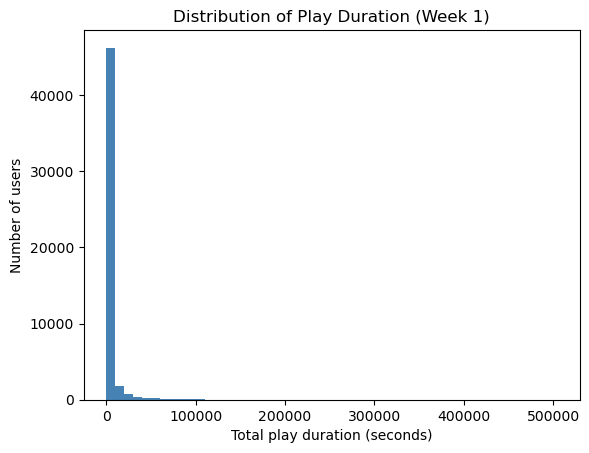

In [12]:
plt.hist(train_df['duration'], bins=50, color='steelblue')
plt.title("Distribution of Play Duration (Week 1)")
plt.xlabel("Total play duration (seconds)")
plt.ylabel("Number of users")
plt.show()


A large spike near the low end indicates many users quit early (small total duration), which likely corresponds to churners. A smaller number of users accumulated very high playtime, indicating strong engagement (and likely they did not churn).


-----------------------------------------------------------------------------------------------------------------------
Levels Completed (lvl_no): The maximum level reached in a week ranges from 1 up to 900. The median is 13 and mean ~24, indicating a skew (a few players advanced very far). Most users only reach low levels, while a few reach hundreds of levels. This is expected for a casual game – many new players churn early, while a minority become very invested.

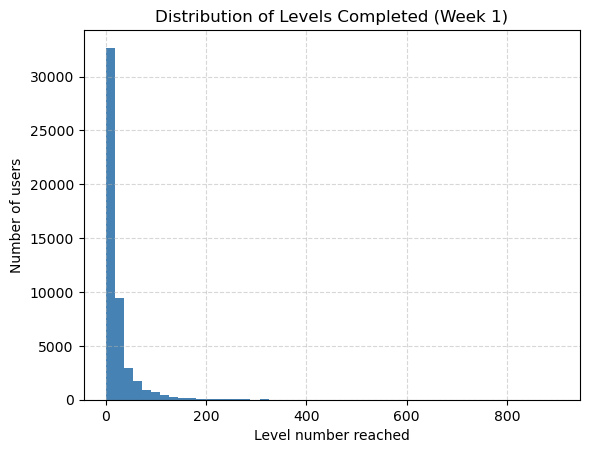

In [13]:
plt.hist(train_df['lvl_no'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Levels Completed (Week 1)")
plt.xlabel("Level number reached")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


-----------------------------------------------------------------------------------------------------------------------
Hint and Bonus usage (hint1_cnt, hint2_cnt, hint3_cnt, bonus_cnt): These counts are often zero for many users (who perhaps didn’t play enough to use hints or not existing because Hint2 and 3 is both 0 and will be droped), with some players using multiple hints. We notice that type1 hints are used more frequently on average than type2 or type3 (likely different hint types or power-ups in the game). The distribution of bonus_cnt (which might be special moves or bonuses used) similarly shows many zeros and a few high values.

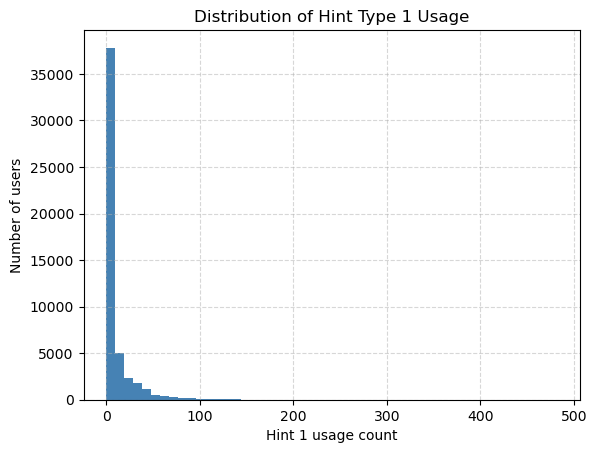

In [14]:
plt.hist(train_df['hint1_cnt'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Hint Type 1 Usage")
plt.xlabel("Hint 1 usage count")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


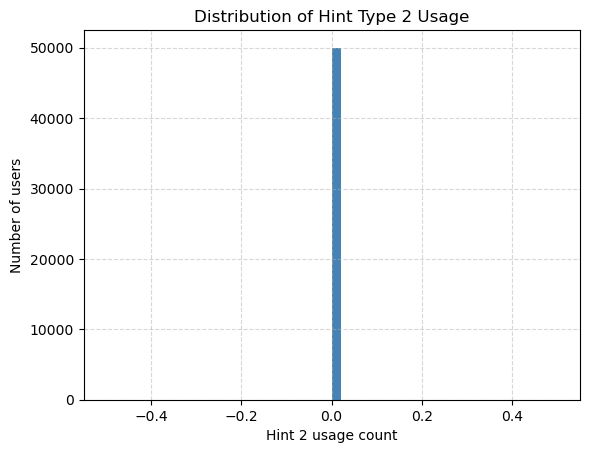

In [15]:
plt.hist(train_df['hint2_cnt'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Hint Type 2 Usage")
plt.xlabel("Hint 2 usage count")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


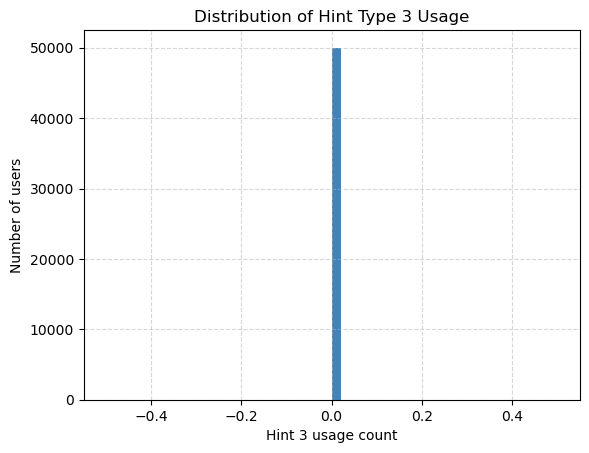

In [16]:
plt.hist(train_df['hint3_cnt'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Hint Type 3 Usage")
plt.xlabel("Hint 3 usage count")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


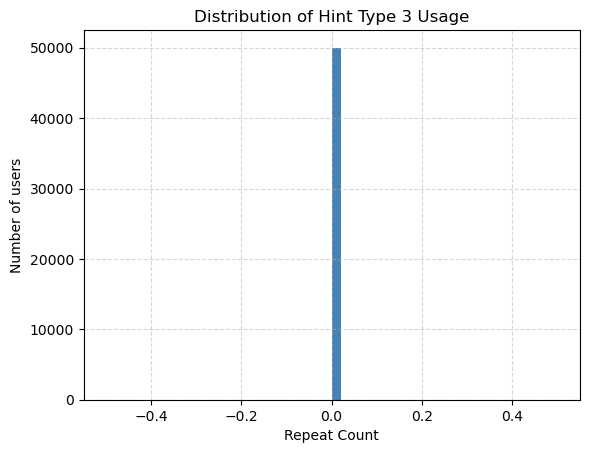

In [17]:
plt.hist(train_df['repeat_cnt'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Hint Type 3 Usage")
plt.xlabel("Repeat Count")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

-----------------------------------------------------------------------------------------------------------------------
In-game currency (current_gold and totalPowerUp): Many players have low gold and few power-ups by end of week1, while a few accumulated a lot (likely those who played many levels). For example, current_gold median might be around a few hundred, with some outliers in the thousands.

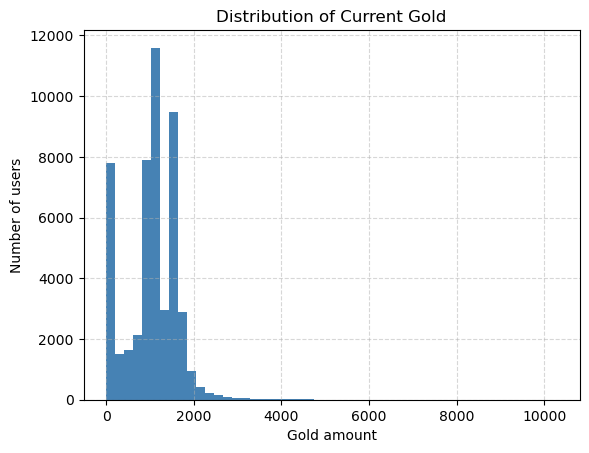

In [18]:
plt.hist(train_df['current_gold'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Current Gold")
plt.xlabel("Gold amount")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


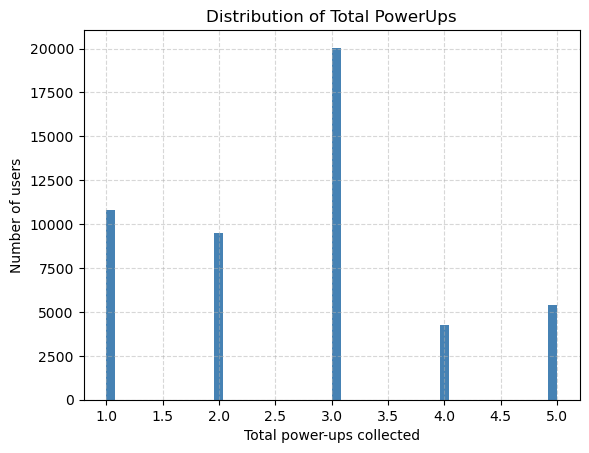

In [19]:
plt.hist(train_df['totalPowerUp'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Total PowerUps")
plt.xlabel("Total power-ups collected")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


-----------------------------------------------------------------------------------------------------------------------
Ad Impressions (banner_impr, inter_impr, rewarded_impr): These count how many ads of each type the user saw in the week. Many users have 0 impressions (perhaps those who didn’t play long enough to see ads), while engaged players see dozens. Notably, inter_impr (interstitial ads) and banner_impr counts can get quite high for the top players, since the game likely shows ads regularly during play.


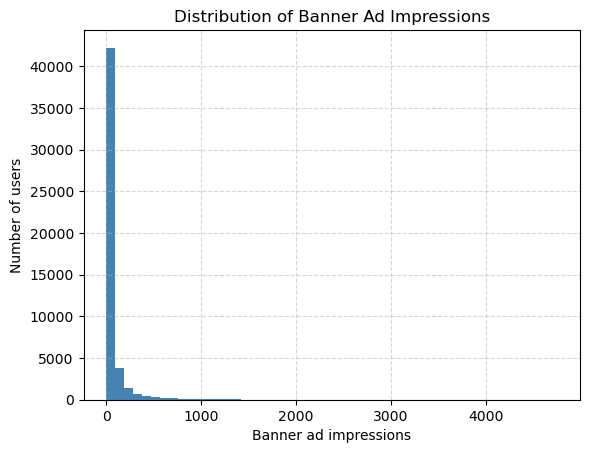

In [20]:
plt.hist(train_df['banner_impr'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Banner Ad Impressions")
plt.xlabel("Banner ad impressions")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


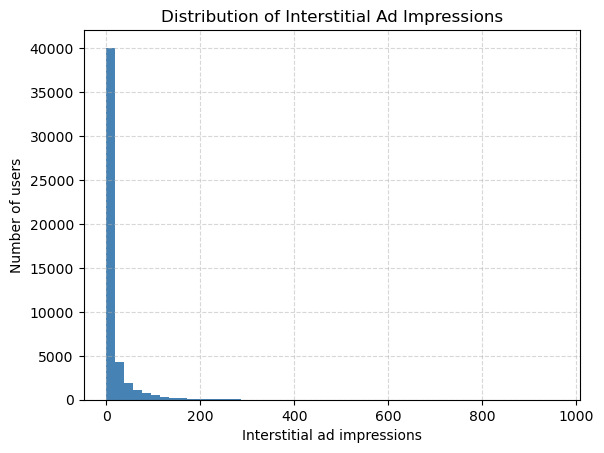

In [21]:
plt.hist(train_df['inter_impr'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Interstitial Ad Impressions")
plt.xlabel("Interstitial ad impressions")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


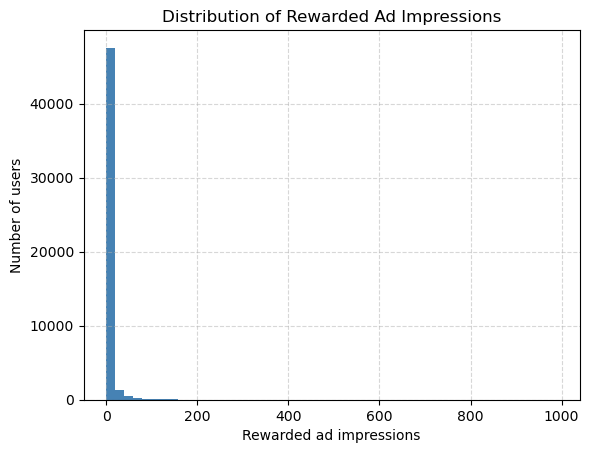

In [22]:
plt.hist(train_df['rewarded_impr'].dropna(), bins=50, color='steelblue')
plt.title("Distribution of Rewarded Ad Impressions")
plt.xlabel("Rewarded ad impressions")
plt.ylabel("Number of users")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## Overall, the numeric features indicate a large variance in engagement: most users exhibit minimal engagement and thus likely churn, whereas a smaller group is highly engaged

In [23]:
# Dropping ineffective Columns 
train_df = train_df.drop(columns=['os', 'hint2_cnt', 'hint3_cnt'])

# Churn Rate by Country

We now analyze churn rate by categorical groups, starting with country. The churn rate is the fraction of users from that group who churned (churn=1). Given the overall churn rate in the data is about 79.6%, we check if some countries perform better or worse:

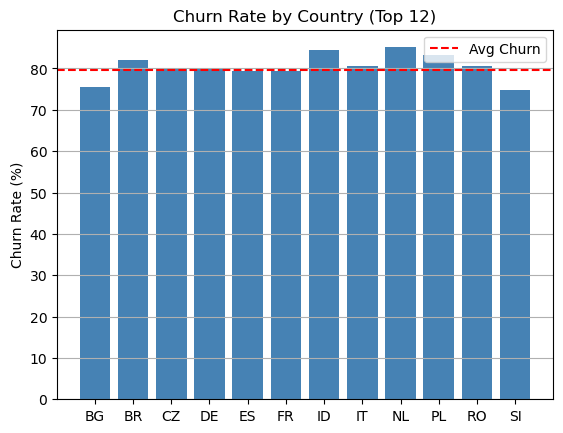

In [24]:
top12 = train_df['country'].value_counts().head(12).index
churn_by_country = train_df[train_df['country'].isin(top12)].groupby('country')['churn'].mean()
avg_churn = train_df['churn'].mean()
plt.bar(churn_by_country.index, churn_by_country.values * 100, color='steelblue')
plt.axhline(avg_churn * 100, color='red', linestyle='--', label='Avg Churn')
plt.title("Churn Rate by Country (Top 12)"); plt.ylabel("Churn Rate (%)")
plt.legend(); plt.grid(True, axis='y'); plt.show()



Churn rate by country for the top 12 countries (by user count). Each bar shows the proportion of users from that country who churned in the first week. From the chart above, we observe slight differences among countries. For example, Netherlands (NL) and Poland (PL) have churn rates above 80% (higher than average), whereas Slovenia (SI) has a churn rate around 75%, the lowest among the top countries. This suggests players from Slovenia retained slightly better than those from some other large markets. Generally, though, all top countries have high churn percentages (75–85%), indicating early churn is a widespread challenge across regions. We might include country in the model to capture these small differences in retention by region.

--------------------------------------------------------------------------------------------------------------------------------------

We can similarly examine churn rate by other categories:


By Partner: Some acquisition partners might yield better retention. For instance, if Partner 4 has a churn rate of say 78% vs Partner 1's 82%, that would indicate Partner 4 brings higher quality users. 


By Campaign: There may be variation across campaigns, though with 33 campaigns, it’s harder to visualize directly. We will let the model figure out campaign effects, but we could compute churn rates per campaign to find top-performing campaigns.

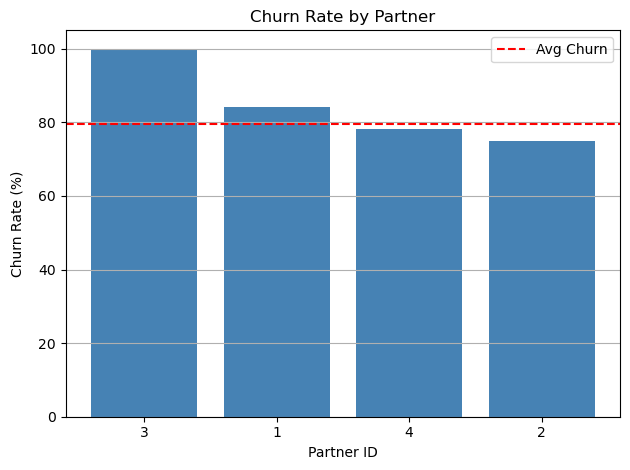

In [25]:
churn_by_partner = train_df.groupby('partnerid')['churn'].mean().sort_values(ascending=False)
plt.bar(churn_by_partner.index.astype(str), churn_by_partner.values * 100, color='steelblue')
plt.axhline(train_df['churn'].mean() * 100, color='red', linestyle='--', label='Avg Churn')
plt.title("Churn Rate by Partner"); plt.xlabel("Partner ID"); plt.ylabel("Churn Rate (%)")
plt.legend(); plt.grid(True, axis='y'); plt.tight_layout(); plt.show()


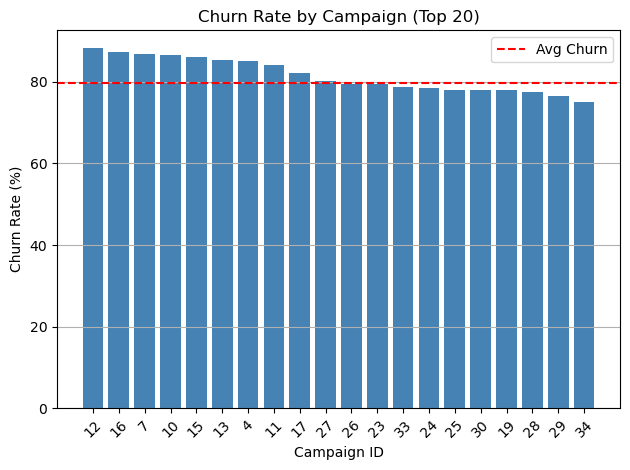

In [26]:
top_campaigns = train_df['campaignid'].value_counts().head(20).index
churn_by_campaign = train_df[train_df['campaignid'].isin(top_campaigns)].groupby('campaignid')['churn'].mean().sort_values(ascending=False)

plt.bar(churn_by_campaign.index.astype(str), churn_by_campaign.values * 100, color='steelblue')
plt.axhline(train_df['churn'].mean() * 100, color='red', linestyle='--', label='Avg Churn')
plt.title("Churn Rate by Campaign (Top 20)"); plt.xlabel("Campaign ID"); plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=45); plt.legend(); plt.grid(True, axis='y'); plt.tight_layout(); plt.show()


-------------------------------------------------------------------------------------------------------------------------------------

Relationship between Acquisition Cost (ECPI) and Level Reached
Next, we explore the relationship between ECPI (the cost paid to acquire a user) and their in-game progress (lvl_no). One might wonder if spending more to acquire a user yields a more engaged player or not. We create a scatter plot of ecpi vs lvl_no:

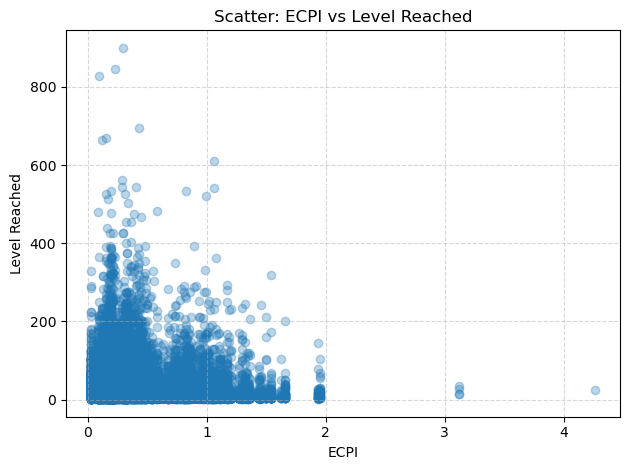

Avg lvl (Top 25% ECPI): 22.2
Avg lvl (Bottom 75% ECPI): 24.54
Pearson r: -0.0179


In [27]:
clean_df = train_df.dropna(subset=['ecpi'])
# Plot entire dataset
plt.scatter(clean_df['ecpi'], clean_df['lvl_no'], alpha=0.3)
plt.title("Scatter: ECPI vs Level Reached")
plt.xlabel("ECPI")
plt.ylabel("Level Reached")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# Compare average levels
q75 = clean_df['ecpi'].quantile(0.75)
print("Avg lvl (Top 25% ECPI):", clean_df[clean_df['ecpi'] > q75]['lvl_no'].mean().round(2))
print("Avg lvl (Bottom 75% ECPI):", clean_df[clean_df['ecpi'] <= q75]['lvl_no'].mean().round(2))
# Compute correlation
print("Pearson r:", clean_df['ecpi'].corr(clean_df['lvl_no']).round(4))

    There is no strong visible correlation between the cost of acquisition and the level reached. Players acquired at both high and low costs show a wide range of levels. This is confirmed by a low Pearson correlation (r ≈ –0.018 between ecpi and lvl_no). In fact, if we compare the average level of users in the top 25% ECPI vs bottom 75% ECPI, they are quite similar. This suggests that paying more per user did not guarantee more engaged players (if anything, our data showed a slightly lower average level for the highest-cost users). Thus, ECPI is largely independent of user engagement – it likely reflects marketing campaign economics rather than user quality. However, ECPI might still indirectly relate to churn through campaign or country effects. We will keep ecpi as a feature (after imputing missing values) to let the model capture any patterns, but we should be cautious that its predictive power may be limited.

# Feature Correlation Analysis
    To avoid multicollinearity and redundancy, we examine the correlation matrix for numeric features. Strongly correlated features provide similar information, so we may consider dropping one of each such pair.Below we compute Pearson correlations among continuous variables:

In [28]:
import numpy as np
corr = train_df.corr(numeric_only=True)
# Find pairs with high correlation
high_corr_pairs = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and corr.loc[col1, col2] > 0.8:
            high_corr_pairs.append((col1, col2, corr.loc[col1, col2]))
high_corr_pairs


[('bonus_cnt', 'lvl_no', 0.8096610475012799),
 ('bonus_cnt', 'inter_impr', 0.8173171443041394),
 ('lvl_no', 'bonus_cnt', 0.8096610475012799),
 ('lvl_no', 'banner_impr', 0.8105713202305896),
 ('lvl_no', 'inter_impr', 0.9705075986218769),
 ('banner_impr', 'lvl_no', 0.8105713202305896),
 ('banner_impr', 'inter_impr', 0.8511716000059351),
 ('inter_impr', 'bonus_cnt', 0.8173171443041394),
 ('inter_impr', 'lvl_no', 0.9705075986218769),
 ('inter_impr', 'banner_impr', 0.8511716000059351),
 ('campaignid', 'partnerid', 0.8474247487982145),
 ('partnerid', 'campaignid', 0.8474247487982145)]

    This reveals several highly correlated pairs:
lvl_no (levels) and inter_impr (interstitial ad views): correlation ≈ 0.97, an extremely high correlation. This makes sense – the more levels a user plays, the more interstitial ads they will see. These two features are almost interchangeable in terms of information.


lvl_no and banner_impr: correlation ≈ 0.81. Similarly, players who progress further see more banner ads.


hint1_cnt and lvl_no: correlation ≈ 0.76. Using more hints correlates with reaching more levels (since engaged players do both).


bonus_cnt and lvl_no: correlation ≈ 0.81. More bonuses used with more levels.


Several other pairs like hint1_cnt with inter_impr (~0.76), bonus_cnt with inter_impr (~0.82), etc., all indicating a common underlying factor: player engagement. Essentially, features measuring engagement (levels, playtime, ads viewed, hints used, etc.) are all positively correlated with each other.


Because of these redundancies, we will drop some features to reduce duplication:

    Because of these redundancies, we will drop some features to reduce duplication:
    We drop inter_impr (interstitial ad count) and keep lvl_no as the representative feature for “game progress/engagement”. Since lvl_no alone captures much of the variance (and is more directly interpretable), removing inter_impr avoids collinearity issues without losing predictive signal.
    We will also drop the unique user_id (player ID) as it has no predictive value for churn.

In [29]:
train_df = train_df.drop(columns=['inter_impr', 'user_id'])


In [30]:
print(train_df.columns)


Index(['country', 'device_brand', 'device_model', 're_install',
       'attribution_event_timestamp', 'ecpi', 'lang', 'current_gold',
       'totalPowerUp', 'bonus_cnt', 'duration', 'hint1_cnt', 'lvl_no',
       'repeat_cnt', 'banner_impr', 'rewarded_impr', 'campaignid', 'partnerid',
       'churn'],
      dtype='object')


 # Feature Engineering: Time-Based Features
    The attribution_event_timestamp gives the date-time when the user was acquired (installed the game)
    Time-related factors could influence user behavior – for example, day of the week or hour of install might correlate with churn (maybe users who install on weekends behave differently than weekdays). We create new features from this timestamp

In [31]:
# Convert timestamp to datetime
train_df['datetime'] = pd.to_datetime(train_df['attribution_event_timestamp'])
# Extract features
train_df['install_hour'] = train_df['datetime'].dt.hour          # Hour of day (0-23)
train_df['install_dayofweek'] = train_df['datetime'].dt.dayofweek  # Day of week (0=Mon, 6=Sun)
train_df['install_weekday'] = (train_df['install_dayofweek'] < 5).astype(int)  # 1 if weekday, 0 if weekend


In [32]:
# Checking is there any significant relationship between Datetime and beign Churn

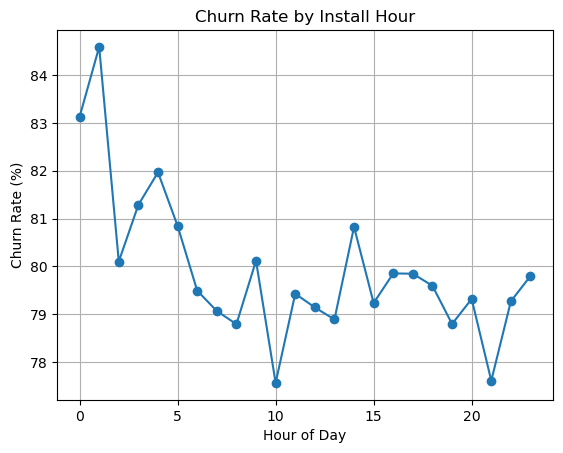

In [33]:
hour_churn = train_df.groupby('install_hour')['churn'].mean()
plt.plot(hour_churn.index, hour_churn.values * 100, marker='o')
plt.title("Churn Rate by Install Hour"); plt.xlabel("Hour of Day"); plt.ylabel("Churn Rate (%)")
plt.grid(True); plt.show()


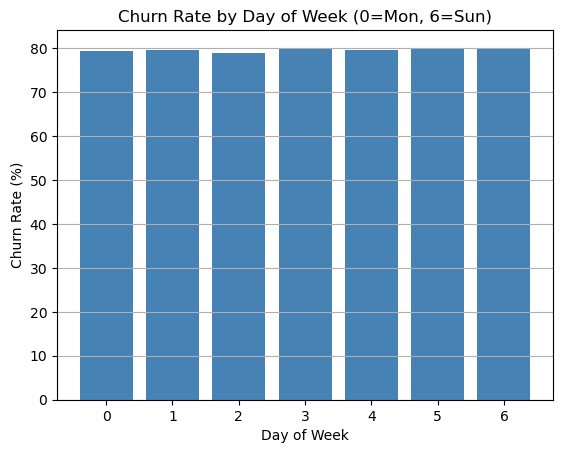

Churn rate by hour:
 install_hour
0     0.831
1     0.846
2     0.801
3     0.813
4     0.820
5     0.808
6     0.795
7     0.791
8     0.788
9     0.801
10    0.776
11    0.794
12    0.791
13    0.789
14    0.808
15    0.792
16    0.799
17    0.798
18    0.796
19    0.788
20    0.793
21    0.776
22    0.793
23    0.798
Name: churn, dtype: float64


In [34]:
dow_churn = train_df.groupby('install_dayofweek')['churn'].mean()
plt.bar(dow_churn.index, dow_churn.values * 100, color='steelblue')
plt.title("Churn Rate by Day of Week (0=Mon, 6=Sun)"); plt.xlabel("Day of Week"); plt.ylabel("Churn Rate (%)")
plt.grid(True, axis='y'); plt.show()

print("Churn rate by hour:\n", hour_churn.round(3))



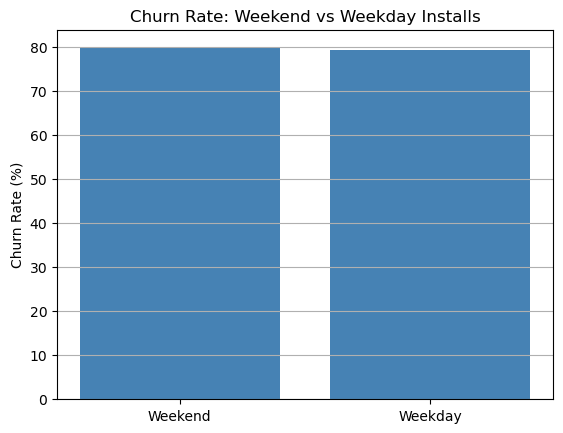

In [35]:
weekday_churn = train_df.groupby('install_weekday')['churn'].mean()
plt.bar(['Weekend', 'Weekday'], weekday_churn.sort_index().values * 100, color='steelblue')
plt.title("Churn Rate: Weekend vs Weekday Installs"); plt.ylabel("Churn Rate (%)")
plt.grid(True, axis='y'); plt.show()


In [36]:
from scipy.stats import f_oneway

# Group churn by each categorical variable
hour_groups = [group['churn'].values for _, group in train_df.groupby('install_hour')]
day_groups = [group['churn'].values for _, group in train_df.groupby('install_dayofweek')]
weekday_groups = [group['churn'].values for _, group in train_df.groupby('install_weekday')]

# Run ANOVA for each
print("ANOVA - install_hour:", f_oneway(*hour_groups))
print("ANOVA - install_dayofweek:", f_oneway(*day_groups))
print("ANOVA - install_weekday:", f_oneway(*weekday_groups))


ANOVA - install_hour: F_onewayResult(statistic=2.4513156930446094, pvalue=0.00012602510878341342)
ANOVA - install_dayofweek: F_onewayResult(statistic=0.6584534998769601, pvalue=0.6833450008958144)
ANOVA - install_weekday: F_onewayResult(statistic=1.8599404852659136, pvalue=0.1726378091498264)


📊 Results Summary:


Feature	F-statistic	p-value	Interpretation


install_hour	2.45	0.00013	✅ Statistically significant – churn varies by hour of day


install_dayofweek	0.66	0.683	❌ Not significant – churn is similar across weekdays


install_weekday	1.86	0.173	❌ Not significant – no clear difference between weekday/weekend


Even though addın install_hour is enough for model in order to just be sure I will add all of them 


    With EDA complete, we have a good understanding of the data. We will now proceed to preprocess the data and build predictive models.

## Part 2: Modeling and Prediction

# Handling Missing Values (ECPI Imputation)

As noted, the feature ECPI (cost per acquisition) has some missing values (528 in train, 58 in test). Rather than drop these users, we fill them using regression imputation


. This means we’ll train a regression model to predict ECPI from other known features:
Why regression? Unlike mean imputation, regression imputation uses relationships with other variables to estimate missing values


. For ECPI, it’s reasonable to use features like campaignid, partnerid, country, etc., which likely determine the cost (marketing campaigns have fixed costs per user, differing by channel and region).


# 1- Imputation Set Up 

In [37]:
# --------------------------- SET-UP --------------------------- #
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer      # ← import FunctionTransformer here
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor

DROP_COLS = ['os', 'hint2_cnt', 'hint3_cnt','user_id','device_model','repeat_cnt']  # already decided # maybe inter_impr will be addded but not sure 
train_df = pd.read_excel('train_data.xlsx')
df = train_df.drop(columns=DROP_COLS)  

def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts attribution_event_timestamp → install_hour, install_dayofweek, install_weekday
    then drops the raw timestamp column.
    """
    df = df.copy()
    dt       = pd.to_datetime(df['attribution_event_timestamp'], errors='coerce')
    df['install_hour']       = dt.dt.hour
    df['install_dayofweek']  = dt.dt.dayofweek
    df['install_weekday']    = (df['install_dayofweek'] < 5).astype(int)
    return df.drop(columns='attribution_event_timestamp', errors='ignore')


In [38]:
# ----------------- 1) keep only rows with ECPI ---------------- #
df_notna = df[df['ecpi'].notna()].reset_index(drop=True)
y        = df_notna['ecpi']
X        = df_notna.drop(columns=['ecpi', 'churn'])                    # churn not a predictor

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=42)

In [39]:
# ----------------- 2) Custom Transformer --------------------- #
class TopFreqGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.top_per_col_ = {}

    def fit(self, X, y=None):
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            self.top_per_col_[col] = freq[freq >= self.threshold].index
        return self

    def transform(self, X):
        X = X.copy()
        for col, top in self.top_per_col_.items():
            X[col] = np.where(X[col].isin(top), X[col], "OTHER")
        return X


In [40]:
# ----------------- 3) Preprocessing -------------------------- #
cat_cols = X.select_dtypes('object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

cat_pipe = Pipeline([
    ('grouper', TopFreqGrouper(threshold=0.01)),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

pre = ColumnTransformer([
    # add your time-feature extractor as the very first step
    # if you really want to extract hour/day/etc, use extract_time_features here:
    ('time', FunctionTransformer(extract_time_features, validate=False), ['attribution_event_timestamp']),
    ('cat' , cat_pipe,  cat_cols),
    ('num' , 'passthrough', num_cols)
])

In [41]:
# ----------------- 4) RMSE Helper ---------------------------- #
def rmse(est, Xtr=X_train, ytr=y_train, Xv=X_val, yv=y_val):
    cv = -cross_val_score(est, Xtr, ytr,
                          cv=KFold(5, shuffle=True, random_state=42),
                          scoring='neg_root_mean_squared_error').mean()
    est.fit(Xtr, ytr)
    val = mean_squared_error(yv, est.predict(Xv), squared=False)
    return cv, val, est

results = {}

In [42]:
# Testing the models

In [43]:
# ----------------- 5) Linear Regression ---------------------- 
lin = Pipeline([('pre', pre), ('lr', LinearRegression())])
cv_rmse, val_rmse, lin_fitted = rmse(lin)
results['Linear'] = (cv_rmse, val_rmse)

# Extract linear regression equation
#             ↓ use transformers_[1] (the 'cat' pipeline), not transformers_[0]
feat_names = (
    lin_fitted
    .named_steps['pre']
    .transformers_[1][1]                    # <- Pipeline(cat)
    .named_steps['ohe']                     # <- OneHotEncoder
    .get_feature_names_out(cat_cols)        # <- feature names
    .tolist()
    + num_cols
)

coef      = lin_fitted.named_steps['lr'].coef_
intercept = lin_fitted.named_steps['lr'].intercept_

equation = (
    f"ECPI = {intercept:.4f} + "
    + " + ".join(f"{c:.4f}*{f}" for c, f in zip(coef, feat_names))
)
print("\nLinear Regression Equation:\n", equation)



Linear Regression Equation:
 ECPI = 0.7852 + -0.0011*country_AZ + 0.0037*country_BE + 0.0233*country_BG + -0.0620*country_BR + -0.0053*country_CA + -0.0641*country_CZ + -0.1089*country_DE + 0.2859*country_ES + 0.0038*country_FR + 0.0939*country_GR + 0.0135*country_ID + -0.0513*country_IT + -0.0394*country_MX + -0.1173*country_NL + -0.0485*country_OTHER + -0.0380*country_PL + 0.2020*country_PT + -0.1200*country_RO + 0.0079*country_SI + -0.0443*country_SK + -0.0463*country_US + -0.0837*country_VE + -0.0185*device_brand_HONOR + 0.3145*device_brand_HUAWEI + -0.0738*device_brand_LENOVO + -0.0052*device_brand_OPPO + -0.0014*device_brand_OTHER + 0.0065*device_brand_Xiaomi + -0.0067*device_brand_motorola + 0.0027*device_brand_realme + -0.0028*device_brand_samsung + 0.0118*device_brand_vivo + -0.0138*attribution_event_timestamp_OTHER + 0.0224*lang_AZ + -0.0136*lang_BR + 0.0000*lang_BU + -0.0543*lang_CS + -0.0987*lang_DE + -0.0540*lang_EN + 0.0041*lang_ES + 0.1015*lang_FR + 0.2879*lang_GR + -0.

/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [44]:
# ----------------- 6) Lasso Regression ----------------------- #
lasso = Pipeline([
    ('pre', pre),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=5000))
])
cv_rmse, val_rmse, lasso_fitted = rmse(lasso)
results['Lasso'] = (cv_rmse, val_rmse)

# Extract non-zero Lasso terms
lasso_coef = lasso_fitted.named_steps['lasso'].coef_
intercept = lasso_fitted.named_steps['lasso'].intercept_
nz = [(f, c) for f, c in zip(feat_names, lasso_coef) if abs(c) > 1e-6]
print("\nLasso Regression (Non-zero Features):")
print(f"ECPI = {intercept:.4f} + " + " + ".join(f"{c:.4f}*{f}" for f, c in nz))



Lasso Regression (Non-zero Features):
ECPI = 0.7985 + 0.0000*duration + -0.0001*lvl_no + 0.0001*campaignid


/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
# ----------------- 7) Decision Tree -------------------------- #
tree = Pipeline([('pre', pre),
                 ('dt', DecisionTreeRegressor(random_state=42))])
results['DecisionTree'] = rmse(tree)[:2]

/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [46]:
rf = Pipeline([('pre', pre),
               ('rf', RandomForestRegressor(
                   n_estimators=100, max_depth=None,
                   n_jobs=-1, random_state=42))])
results['RandomForest'] = rmse(rf)[:2]


/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
# ----------------- 9) XGBoost ------------------------------- #
xgb = Pipeline([('pre', pre),
                ('xgb', XGBRegressor(
                    n_estimators=400, learning_rate=0.05, max_depth=6,
                    subsample=0.8, colsample_bytree=0.8,
                    objective='reg:squarederror', random_state=42, n_jobs=-1))])
results['XGBoost'] = rmse(xgb)[:2]


/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [48]:
# ----------------- 10) Show Results ------------------------- #
print("\nModel RMSE (lower is better):")
print(pd.DataFrame(results, index=['CV_RMSE', 'Val_RMSE']).T.round(5))


Model RMSE (lower is better):
              CV_RMSE  Val_RMSE
Linear        0.15208   0.15605
Lasso         0.23732   0.23738
DecisionTree  0.08581   0.07482
RandomForest  0.06469   0.05319
XGBoost       0.06619   0.05597


So as the results shows best regressor model for ECPI imputation is XGboost

In [49]:
# ------------------------------------------------------------------
# 11)  Fit the best XGBoost model on the full, non-null ECPI subset
# ------------------------------------------------------------------
best_xgb = Pipeline([
    ('pre', pre),                     # <-- same preprocessing object you built above
    ('xgb', XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        objective='reg:squarederror', random_state=42, n_jobs=-1))
])

best_xgb.fit(X, y)                    # X and y are the full non-null sets


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('time',
                                                  FunctionTransformer(func=<function extract_time_features at 0x17f068ea0>),
                                                  ['attribution_event_timestamp']),
                                                 ('cat',
                                                  Pipeline(steps=[('grouper',
                                                                   TopFreqGrouper()),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'device_brand',
                                                   'attribution_event_timestamp',
                                                   'lang']),
                                                 ('num', 'passthrou...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=400, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [50]:
# ------------------------------------------------------------------
# 12)  Impute missing ECPI in the *training* data
# ------------------------------------------------------------------
train_missing_idx = df[df['ecpi'].isna()].index
if len(train_missing_idx):
    X_missing_train = df.loc[train_missing_idx].drop(columns=['ecpi', 'churn'], errors='ignore')
    df.loc[train_missing_idx, 'ecpi'] = best_xgb.predict(X_missing_train)
    print(f"Filled {len(train_missing_idx)} ECPI values in the training set.")
else:
    print("No missing ECPI rows in training set.")

Filled 528 ECPI values in the training set.


In [51]:
# ------------------------------------------------------------------
# Impute missing ECPI in the *test* data – same pattern as the train block
# ------------------------------------------------------------------
test_missing_idx = test_df[test_df['ecpi'].isna()].index

if len(test_missing_idx):
    X_missing_test = (
        test_df
        .loc[test_missing_idx]
        .drop(columns=['ecpi', 'churn'], errors='ignore')   # keep it identical to the train logic
    )
    test_df.loc[test_missing_idx, 'ecpi'] = best_xgb.predict(X_missing_test)
    print(f"Filled {len(test_missing_idx)} ECPI values in the test set.")
else:
    print("No missing ECPI rows in test set.")


Filled 58 ECPI values in the test set.


In [52]:
# --------------------  Quick sanity checks  ---------------------
print("\nRemaining nulls →  Train:", df['ecpi'].isna().sum(),
      "|  Test:", test_df['ecpi'].isna().sum())

print("\nTrain head (after fill):")
display(df.head())

print("\nTest head (after fill):")
display(test_df.head())


Remaining nulls →  Train: 0 |  Test: 0

Train head (after fill):


,country,device_brand,re_install,attribution_event_timestamp,ecpi,lang,current_gold,totalPowerUp,bonus_cnt,duration,hint1_cnt,lvl_no,banner_impr,inter_impr,rewarded_impr,campaignid,partnerid,churn
0,CZ,Blackview,0,2025-01-06 15:12:35.000,0.279937,CS,120,3,17,3989,37,26,28,19,10,24,4,1
1,AT,samsung,0,2025-01-19 16:50:59.000,0.389500,DE,65,1,41,8427,46,62,239,55,12,25,4,1
2,BG,HONOR,0,2025-01-19 08:46:42.000,0.155800,BU,1700,5,7,2674,0,36,107,26,1,25,4,1
3,AZ,samsung,0,2025-01-11 09:10:43.000,0.098094,AZ,340,3,7,512,28,25,4,11,0,34,4,1
4,AZ,samsung,0,2025-01-16 16:45:16.000,0.083373,AZ,660,1,0,978,11,14,32,2,0,34,4,0



Test head (after fill):


,test_id,country,device_brand,device_model,re_install,os,attribution_event_timestamp,ecpi,lang,current_gold,...,hint2_cnt,hint3_cnt,lvl_no,repeat_cnt,banner_impr,inter_impr,rewarded_impr,user_id,campaignid,partnerid
0,1,SI,samsung,SM-A226B,0,android,2025-01-23 19:06:55.000,0.192110,SL,1545,...,0,0,12,0,13,0,1,9280,25,4
1,2,US,samsung,SM-T560NU,0,android,2025-01-07 15:13:13.000,0.967698,EN,1000,...,0,0,4,0,2,0,0,9300,24,4
2,3,DZ,samsung,SM-A042F,0,android,2025-01-20 22:39:01.000,0.029018,EN,1020,...,0,0,5,0,1,0,0,9320,33,4
3,4,FR,samsung,SM-T500,0,android,2025-01-01 20:49:31.000,0.328321,FR,1795,...,0,0,38,0,89,27,1,9340,27,4
4,5,RO,samsung,SM-A145R,0,android,2025-01-04 23:18:30.000,0.176787,RO,35,...,0,0,6,0,2,0,0,9360,23,4


 # MODEL DEVELOPMENT 

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is already preprocessed (ECPI filled), test_df is not needed now
df_model = df.copy()
df_test = test_df.copy()


df_model['attribution_event_timestamp'] = pd.to_datetime(df['attribution_event_timestamp'])
df_model['week'] = df_model['attribution_event_timestamp'].dt.isocalendar().week
df_model['hour'] = df_model['attribution_event_timestamp'].dt.hour
df_model['day'] = df_model['attribution_event_timestamp'].dt.dayofweek  # 0=Monday

df_model = df_model.drop(columns=['attribution_event_timestamp'])

In [54]:
df_model.head()

,country,device_brand,re_install,ecpi,lang,current_gold,totalPowerUp,bonus_cnt,duration,hint1_cnt,lvl_no,banner_impr,inter_impr,rewarded_impr,campaignid,partnerid,churn,week,hour,day
0,CZ,Blackview,0,0.279937,CS,120,3,17,3989,37,26,28,19,10,24,4,1,2,15,0
1,AT,samsung,0,0.389500,DE,65,1,41,8427,46,62,239,55,12,25,4,1,3,16,6
2,BG,HONOR,0,0.155800,BU,1700,5,7,2674,0,36,107,26,1,25,4,1,3,8,6
3,AZ,samsung,0,0.098094,AZ,340,3,7,512,28,25,4,11,0,34,4,1,2,9,5
4,AZ,samsung,0,0.083373,AZ,660,1,0,978,11,14,32,2,0,34,4,0,3,16,3


In [55]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_model, test_size=0.1, random_state=42, shuffle=True)


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

cat_cols = ['country', 'device_brand', 're_install', 'lang', 'campaignid', 'partnerid']

# 1. Split train/validation
train_df, val_df = train_test_split(df_model, test_size=0.1, random_state=42, shuffle=True)

# 2. Rare category grouping (fit only on train, map to both)
for col in cat_cols:
    freq = train_df[col].value_counts(normalize=True)
    rare_cats = freq[freq < 0.01].index
    train_df[col] = train_df[col].replace(rare_cats, 'other')
    val_df[col] = val_df[col].replace(rare_cats, 'other')

# --- ENSURE CATEGORICAL COLUMNS ARE STRING ---
train_df[cat_cols] = train_df[cat_cols].astype(str)
val_df[cat_cols]   = val_df[cat_cols].astype(str)

# 3. One-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_df[cat_cols])

train_encoded = encoder.transform(train_df[cat_cols])
val_encoded = encoder.transform(val_df[cat_cols])

# Back to DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(cat_cols), index=train_df.index)
val_encoded_df = pd.DataFrame(val_encoded, columns=encoder.get_feature_names_out(cat_cols), index=val_df.index)

# Merge back (drop original categorical columns)
train_final = pd.concat([train_df.drop(columns=cat_cols), train_encoded_df], axis=1)
val_final = pd.concat([val_df.drop(columns=cat_cols), val_encoded_df], axis=1)

# (Optional) Reset index if you want clean DataFrames
train_final = train_final.reset_index(drop=True)
val_final = val_final.reset_index(drop=True)

# Check result
print(train_final.shape, val_final.shape)
print(train_final.head())


(44999, 87) (5000, 87)
       ecpi  current_gold  totalPowerUp  bonus_cnt  duration  hint1_cnt  \
0  0.489400           920             2          0        16          2   
1  0.153840          1020             3          0         7          0   
2  0.191890          1165             3          0       426          0   
3  0.213389          1115             1          1      1492          1   
4  0.326587          1620             5          9       371          0   

   lvl_no  banner_impr  inter_impr  rewarded_impr  ...  campaignid_27  \
0       5            1           0              1  ...            0.0   
1       5            2           0              0  ...            0.0   
2       5            5           0              4  ...            0.0   
3      10           26           0              3  ...            1.0   
4      15           32           2              4  ...            0.0   

   campaignid_28  campaignid_29  campaignid_30  campaignid_33  campaignid_34  \
0      

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prepare X, y
X_train = train_final.drop(columns=['churn'])
y_train = train_final['churn']
X_val = val_final.drop(columns=['churn'])
y_val = val_final['churn']

results = {}

def evaluate_model(name, model, X_val, y_val, proba=None):
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    # Specificity: TN / (TN + FP)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp)
    if proba is None:
        proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, proba)
    fpr, tpr, thresholds = roc_curve(y_val, proba)
    print(f"\n--- {name} ---")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Specificity: {spec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_val, y_pred))
    # Store results
    results[name] = dict(
        accuracy=acc, precision=prec, recall=rec, specificity=spec, f1=f1, auc=auc, cm=cm, fpr=fpr, tpr=tpr
    )
    # Plot ROC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.figure(figsize=(10, 8))


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>


--- Logistic Regression ---
Confusion Matrix:
[[ 416  595]
 [ 145 3844]]
Accuracy: 0.8520
Precision: 0.8660
Recall: 0.9637
Specificity: 0.4115
F1 Score: 0.9122
AUC: 0.8136
              precision    recall  f1-score   support

           0       0.74      0.41      0.53      1011
           1       0.87      0.96      0.91      3989

    accuracy                           0.85      5000
   macro avg       0.80      0.69      0.72      5000
weighted avg       0.84      0.85      0.83      5000



/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


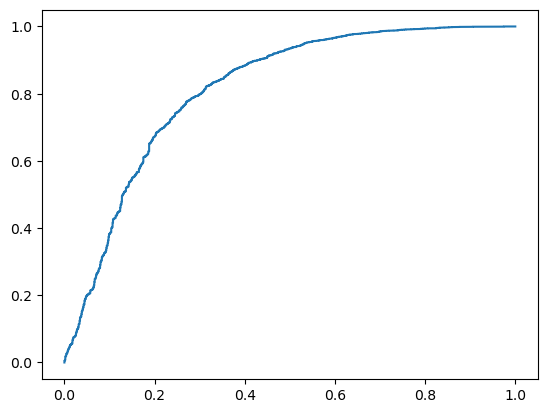

In [58]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
evaluate_model('Logistic Regression', log_reg, X_val, y_val)


/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



--- Poly Logistic Regression ---
Confusion Matrix:
[[ 586  425]
 [ 586 3403]]
Accuracy: 0.7978
Precision: 0.8890
Recall: 0.8531
Specificity: 0.5796
F1 Score: 0.8707
AUC: 0.7229
              precision    recall  f1-score   support

           0       0.50      0.58      0.54      1011
           1       0.89      0.85      0.87      3989

    accuracy                           0.80      5000
   macro avg       0.69      0.72      0.70      5000
weighted avg       0.81      0.80      0.80      5000



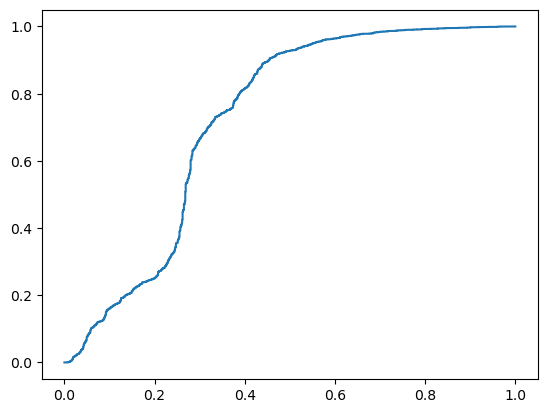

In [59]:
# Polynomial Logistic Regression (degree=2 for illustration)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
log_reg_poly = LogisticRegression(max_iter=1000)
log_reg_poly.fit(X_train_poly, y_train)
evaluate_model('Poly Logistic Regression', log_reg_poly, X_val_poly, y_val)



--- LDA ---
Confusion Matrix:
[[ 357  654]
 [  92 3897]]
Accuracy: 0.8508
Precision: 0.8563
Recall: 0.9769
Specificity: 0.3531
F1 Score: 0.9126
AUC: 0.8434
              precision    recall  f1-score   support

           0       0.80      0.35      0.49      1011
           1       0.86      0.98      0.91      3989

    accuracy                           0.85      5000
   macro avg       0.83      0.67      0.70      5000
weighted avg       0.84      0.85      0.83      5000



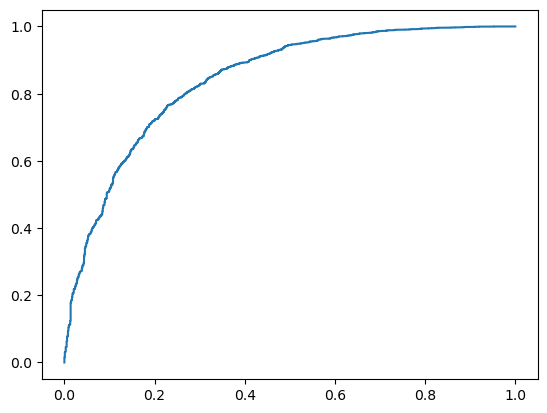

In [60]:
# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
evaluate_model('LDA', lda, X_val, y_val)



--- Decision Tree ---
Confusion Matrix:
[[ 516  495]
 [ 523 3466]]
Accuracy: 0.7964
Precision: 0.8750
Recall: 0.8689
Specificity: 0.5104
F1 Score: 0.8719
AUC: 0.6896
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      1011
           1       0.88      0.87      0.87      3989

    accuracy                           0.80      5000
   macro avg       0.69      0.69      0.69      5000
weighted avg       0.80      0.80      0.80      5000



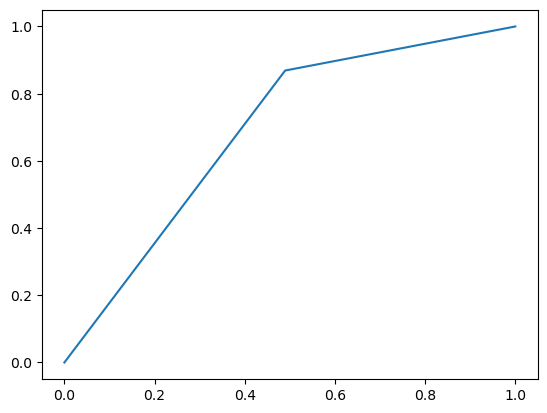

In [61]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
evaluate_model('Decision Tree', dt, X_val, y_val)



--- Random Forest ---
Confusion Matrix:
[[ 516  495]
 [ 213 3776]]
Accuracy: 0.8584
Precision: 0.8841
Recall: 0.9466
Specificity: 0.5104
F1 Score: 0.9143
AUC: 0.8588
              precision    recall  f1-score   support

           0       0.71      0.51      0.59      1011
           1       0.88      0.95      0.91      3989

    accuracy                           0.86      5000
   macro avg       0.80      0.73      0.75      5000
weighted avg       0.85      0.86      0.85      5000



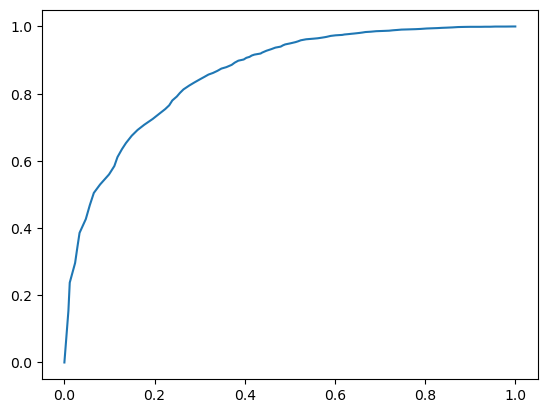

In [62]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model('Random Forest', rf, X_val, y_val)


/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:55:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
Confusion Matrix:
[[ 512  499]
 [ 216 3773]]
Accuracy: 0.8570
Precision: 0.8832
Recall: 0.9459
Specificity: 0.5064
F1 Score: 0.9134
AUC: 0.8597
              precision    recall  f1-score   support

           0       0.70      0.51      0.59      1011
           1       0.88      0.95      0.91      3989

    accuracy                           0.86      5000
   macro avg       0.79      0.73      0.75      5000
weighted avg       0.85      0.86      0.85      5000



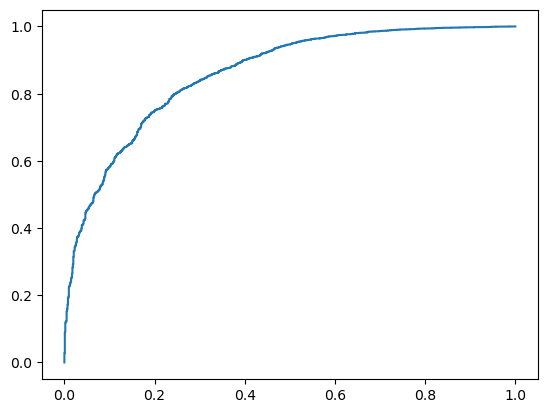

In [63]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
evaluate_model('XGBoost', xgb, X_val, y_val)

In [64]:
# Create results table
results_df = pd.DataFrame(results).T
print("\nSummary Table:")
display(results_df[['accuracy', 'precision', 'recall', 'specificity', 'f1', 'auc']])


Summary Table:


,accuracy,precision,recall,specificity,f1,auc
Logistic Regression,0.852,0.865961,0.96365,0.411474,0.912197,0.813624
Poly Logistic Regression,0.7978,0.888976,0.853096,0.579624,0.870666,0.722868
LDA,0.8508,0.856295,0.976937,0.353116,0.912646,0.843357
Decision Tree,0.7964,0.875032,0.868889,0.510386,0.87195,0.689638
Random Forest,0.8584,0.884102,0.946603,0.510386,0.914286,0.858849
XGBoost,0.857,0.883193,0.945851,0.506429,0.913449,0.859699


# Testing New Things

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve
)
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Copy data
df_model = df.copy()
df_test = test_df.copy()

# Ensure datetime format
df_model['attribution_event_timestamp'] = pd.to_datetime(df_model['attribution_event_timestamp'])

# Extract time-based features
df_model['week'] = df_model['attribution_event_timestamp'].dt.isocalendar().week
df_model['hour'] = df_model['attribution_event_timestamp'].dt.hour
df_model['day'] = df_model['attribution_event_timestamp'].dt.dayofweek  # 0 = Monday

# Preview
df_model.head()


,country,device_brand,re_install,attribution_event_timestamp,ecpi,lang,current_gold,totalPowerUp,bonus_cnt,duration,...,lvl_no,banner_impr,inter_impr,rewarded_impr,campaignid,partnerid,churn,week,hour,day
0,CZ,Blackview,0,2025-01-06 15:12:35,0.279937,CS,120,3,17,3989,...,26,28,19,10,24,4,1,2,15,0
1,AT,samsung,0,2025-01-19 16:50:59,0.389500,DE,65,1,41,8427,...,62,239,55,12,25,4,1,3,16,6
2,BG,HONOR,0,2025-01-19 08:46:42,0.155800,BU,1700,5,7,2674,...,36,107,26,1,25,4,1,3,8,6
3,AZ,samsung,0,2025-01-11 09:10:43,0.098094,AZ,340,3,7,512,...,25,4,11,0,34,4,1,2,9,5
4,AZ,samsung,0,2025-01-16 16:45:16,0.083373,AZ,660,1,0,978,...,14,32,2,0,34,4,0,3,16,3


In [66]:
# Step 1: Drop timestamp and lang columns
df_model = df_model.drop(columns=["attribution_event_timestamp", "lang"])

# Step 2: Define columns to one-hot encode
OHE_COLS = ["campaignid", "partnerid", "week", "hour", "day", "re_install","country","device_brand"]

# Step 3: Apply one-hot encoding using pandas
df_model = pd.get_dummies(df_model, columns=OHE_COLS, drop_first=True)

# Quick check
print("Final shape after encoding:", df_model.shape)
df_model.head()

Final shape after encoding: (49999, 482)


,ecpi,current_gold,totalPowerUp,bonus_cnt,duration,hint1_cnt,lvl_no,banner_impr,inter_impr,rewarded_impr,...,device_brand_reeder,device_brand_revoview,device_brand_rockchip,device_brand_samsung,device_brand_sanmu,device_brand_skythtek,device_brand_sprd,device_brand_vivo,device_brand_wheatek,device_brand_worldchip
0,0.279937,120,3,17,3989,37,26,28,19,10,...,False,False,False,False,False,False,False,False,False,False
1,0.389500,65,1,41,8427,46,62,239,55,12,...,False,False,False,True,False,False,False,False,False,False
2,0.155800,1700,5,7,2674,0,36,107,26,1,...,False,False,False,False,False,False,False,False,False,False
3,0.098094,340,3,7,512,28,25,4,11,0,...,False,False,False,True,False,False,False,False,False,False
4,0.083373,660,1,0,978,11,14,32,2,0,...,False,False,False,True,False,False,False,False,False,False


In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Assume df_model is already preprocessed as instructed
# Split features and target
X = df_model.drop(columns=["churn"])
y = df_model["churn"]

# Train/Val split 90/10
X_trainval, X_val, y_trainval, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Models
models = {
    "Logistic": LogisticRegression(max_iter=1000),
    "Lasso": LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:52:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:52:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:52:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/mustafaercengizmacbooku/miniforge3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:52:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use

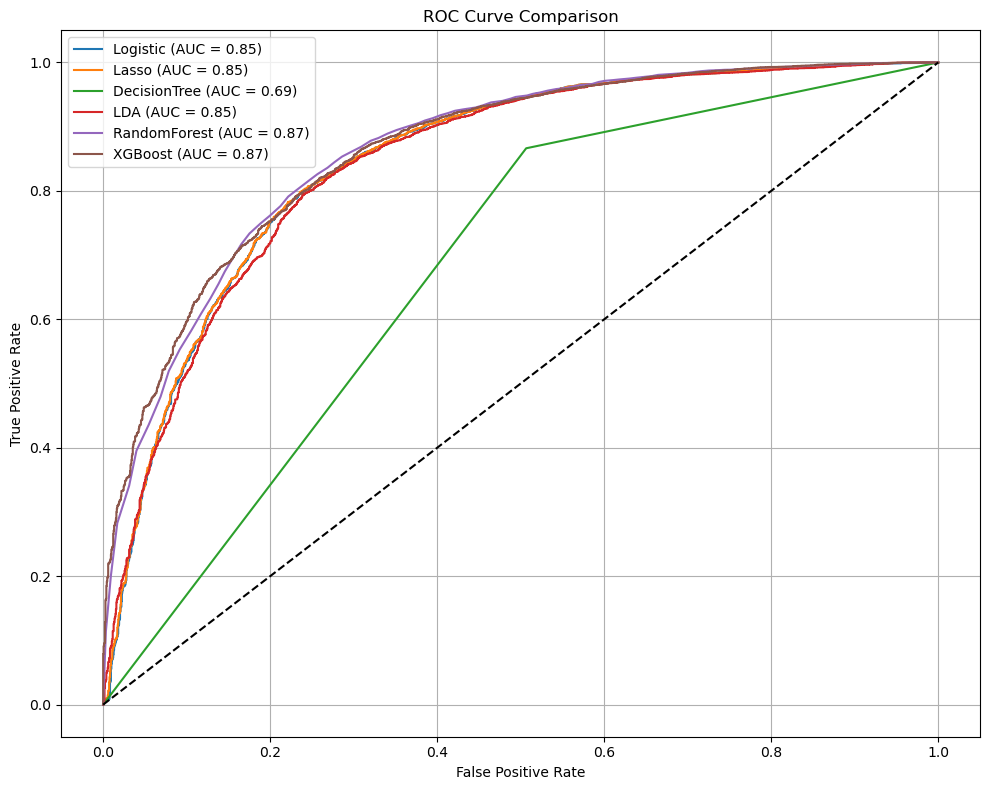

In [69]:
for name, model in models.items():
    accs, precs, recs, f1s, rocs = [], [], [], [], []
    tpr_last, fpr_last = None, None

    for train_idx, test_idx in cv.split(X_trainval, y_trainval):
        X_tr, X_ts = X_trainval.iloc[train_idx], X_trainval.iloc[test_idx]
        y_tr, y_ts = y_trainval.iloc[train_idx], y_trainval.iloc[test_idx]

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])

        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_ts)
        y_prob = pipe.predict_proba(X_ts)[:, 1]

        accs.append(accuracy_score(y_ts, y_pred))
        precs.append(precision_score(y_ts, y_pred))
        recs.append(recall_score(y_ts, y_pred))
        f1s.append(f1_score(y_ts, y_pred))
        rocs.append(roc_auc_score(y_ts, y_prob))

        fpr_last, tpr_last, _ = roc_curve(y_ts, y_prob)

    results[name] = {
        "accuracy": np.mean(accs),
        "precision": np.mean(precs),
        "recall": np.mean(recs),
        "f1_score": np.mean(f1s),
        "roc_auc": np.mean(rocs),
        "conf_matrix": confusion_matrix(y_ts, y_pred),
        "fpr": fpr_last,
        "tpr": tpr_last
    }

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], label=f"{name} (AUC = {res['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [70]:
# Create a summary table excluding FPR/TPR and confusion matrix
summary_df = pd.DataFrame({
    model: {
        "Accuracy": round(metrics["accuracy"], 4),
        "Precision": round(metrics["precision"], 4),
        "Recall": round(metrics["recall"], 4),
        "F1 Score": round(metrics["f1_score"], 4),
        "ROC AUC": round(metrics["roc_auc"], 4)
    }
    for model, metrics in results.items()
}).T

summary_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic,0.8543,0.8654,0.9676,0.9137,0.8479
Lasso,0.8544,0.8654,0.9677,0.9137,0.8491
DecisionTree,0.7929,0.8722,0.8669,0.8696,0.6851
LDA,0.8466,0.8521,0.9769,0.9102,0.8460
RandomForest,0.8579,0.8796,0.9518,0.9143,0.8664
XGBoost,0.8539,0.8780,0.9484,0.9118,0.8656


# Doing it on Test Set

In [73]:
df_test.head()

,test_id,country,device_brand,device_model,re_install,os,attribution_event_timestamp,ecpi,lang,current_gold,...,hint2_cnt,hint3_cnt,lvl_no,repeat_cnt,banner_impr,inter_impr,rewarded_impr,user_id,campaignid,partnerid
0,1,SI,samsung,SM-A226B,0,android,2025-01-23 19:06:55.000,0.192110,SL,1545,...,0,0,12,0,13,0,1,9280,25,4
1,2,US,samsung,SM-T560NU,0,android,2025-01-07 15:13:13.000,0.967698,EN,1000,...,0,0,4,0,2,0,0,9300,24,4
2,3,DZ,samsung,SM-A042F,0,android,2025-01-20 22:39:01.000,0.029018,EN,1020,...,0,0,5,0,1,0,0,9320,33,4
3,4,FR,samsung,SM-T500,0,android,2025-01-01 20:49:31.000,0.328321,FR,1795,...,0,0,38,0,89,27,1,9340,27,4
4,5,RO,samsung,SM-A145R,0,android,2025-01-04 23:18:30.000,0.176787,RO,35,...,0,0,6,0,2,0,0,9360,23,4


In [74]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Load data (assuming df and test_df are already loaded)
df_model = df.copy()
test_df_processed = test_df.copy()

# Preprocess training data
df_model['attribution_event_timestamp'] = pd.to_datetime(df_model['attribution_event_timestamp'])
df_model['week'] = df_model['attribution_event_timestamp'].dt.isocalendar().week
df_model['hour'] = df_model['attribution_event_timestamp'].dt.hour
df_model['day'] = df_model['attribution_event_timestamp'].dt.dayofweek
df_model = df_model.drop(columns=['attribution_event_timestamp', 'lang'])

cat_cols = ['country', 'device_brand', 're_install', 'campaignid', 'partnerid', 'week', 'hour', 'day']

# Handle rare categories in training data
for col in cat_cols:
    df_model[col] = df_model[col].astype(str)
    freq = df_model[col].value_counts(normalize=True)
    rare_cats = freq[freq < 0.01].index
    df_model[col] = df_model[col].replace(rare_cats, 'other')


In [75]:
# Preprocess test data
test_df_processed['attribution_event_timestamp'] = pd.to_datetime(test_df_processed['attribution_event_timestamp'])
test_df_processed['week'] = test_df_processed['attribution_event_timestamp'].dt.isocalendar().week
test_df_processed['hour'] = test_df_processed['attribution_event_timestamp'].dt.hour
test_df_processed['day'] = test_df_processed['attribution_event_timestamp'].dt.dayofweek
test_df_processed = test_df_processed.drop(columns=['attribution_event_timestamp', 'lang'])

# Apply rare categories from training data to test data
for col in cat_cols:
    test_df_processed[col] = test_df_processed[col].astype(str)
    train_cats = df_model[col].unique()
    test_df_processed[col] = test_df_processed[col].apply(lambda x: x if x in train_cats else 'other')

# One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(df_model[cat_cols])

X_train_encoded = encoder.transform(df_model[cat_cols])
X_test_encoded = encoder.transform(test_df_processed[cat_cols])

In [78]:
# Create DataFrames
encoded_cols = encoder.get_feature_names_out(cat_cols)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=df_model.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=test_df_processed.index)

# Combine with numerical features
numerical_cols = df_model.columns.difference(cat_cols + ['churn']).tolist()
X_train_final = pd.concat([df_model[numerical_cols], X_train_encoded_df], axis=1)
X_test_final = pd.concat([test_df_processed[numerical_cols], X_test_encoded_df], axis=1)

# Align test columns with training columns
X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

# Train model on entire training data
y_train = df_model['churn']
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train_final, y_train)


RandomForestClassifier(random_state=42)

In [79]:

# Predict and add to test data
test_predictions = best_model.predict(X_test_final)
test_df['churn'] = test_predictions

# Output (if needed)
test_df[['test_id', 'churn']].to_csv('predictions.csv', index=False)

In [80]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

# 1) ----------  fit XGBoost on the same matrix  ----------
xgb_model = XGBClassifier(
    n_estimators      = 350,      # ↑ trees → usually better with tabular data
    learning_rate     = 0.05,
    max_depth         = 6,
    subsample         = 0.9,
    colsample_bytree  = 0.8,
    eval_metric       = "auc",
    random_state      = 42,
    n_jobs            = -1
)

xgb_model.fit(X_train_final, y_train)

# 2) ----------  predictions & file  ----------
xgb_preds = xgb_model.predict(X_test_final)

out_xgb = pd.DataFrame({
    "test_id": test_df["test_id"],  # adapt if your id column is named differently
    "churn"  : xgb_preds
})
out_xgb.to_csv("prediction_xgb.csv", index=False)
print("✓ Wrote prediction_xgb.csv")

# 3) ----------  simple head-to-head comparison on test preds ----------
rf_preds  = test_predictions                                 # from your Random-Forest run
cmp = pd.DataFrame({"rf_pred": rf_preds, "xgb_pred": xgb_preds})
cmp["agree"] = cmp.rf_pred == cmp.xgb_pred

print("\n== Agreement on TEST set ==")
print(cmp["agree"].value_counts(normalize=True).rename({True:"agree",False:"disagree"}).mul(100).round(2).astype(str) + "%")
print("\nCounts predicted as churn (1):")
print({
    "RandomForest": int((rf_preds==1).sum()),
    "XGBoost"     : int((xgb_preds==1).sum())
})

# 4) ----------  extra: 5-fold CV AUC on TRAIN ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_auc  = cross_val_score(best_model, X_train_final, y_train, cv=cv, scoring="roc_auc")
xgb_auc = cross_val_score(xgb_model,  X_train_final, y_train, cv=cv, scoring="roc_auc")

print(f"\n=== 5-fold CV AUC (train) ===")
print(f"RandomForest : {rf_auc.mean():.4f}  ± {rf_auc.std():.4f}")
print(f"XGBoost      : {xgb_auc.mean():.4f}  ± {xgb_auc.std():.4f}")

# 5) ----------  optional: full classification report on TRAIN ----------
print("\n== Full classification report on training set (fit-on-full) ==")
for name, clf in [("RandomForest", best_model), ("XGBoost", xgb_model)]:
    print(f"\n{name}")
    y_hat = clf.predict(X_train_final)
    print(classification_report(y_train, y_hat, digits=3))


✓ Wrote prediction_xgb.csv

== Agreement on TEST set ==
agree
agree       96.75%
disagree     3.25%
Name: proportion, dtype: object

Counts predicted as churn (1):
{'RandomForest': 5110, 'XGBoost': 5129}

=== 5-fold CV AUC (train) ===
RandomForest : 0.8685  ± 0.0014
XGBoost      : 0.8724  ± 0.0008

== Full classification report on training set (fit-on-full) ==

RandomForest
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     10179
           1      1.000     1.000     1.000     39820

    accuracy                          1.000     49999
   macro avg      1.000     1.000     1.000     49999
weighted avg      1.000     1.000     1.000     49999


XGBoost
              precision    recall  f1-score   support

           0      0.822     0.553     0.661     10179
           1      0.895     0.969     0.930     39820

    accuracy                          0.885     49999
   macro avg      0.858     0.761     0.796     49999
weighted avg   

# INFERENCES 


=== Random-Forest – Top 25 features ===


,Importance
duration,0.120842
lvl_no,0.103946
inter_impr,0.101383
banner_impr,0.097367
bonus_cnt,0.083007
current_gold,0.054182
rewarded_impr,0.048726
hint1_cnt,0.046803
ecpi,0.043514
totalPowerUp,0.021075


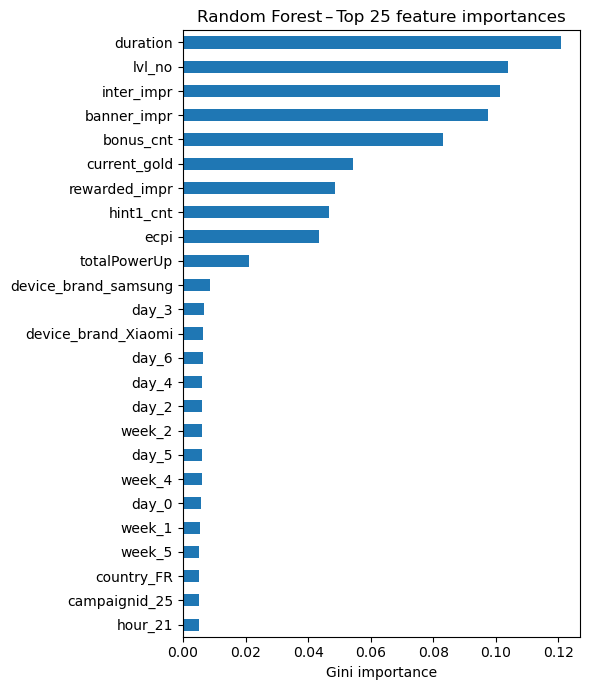


=== XGBoost – Top 25 features ===


,Gain
inter_impr,0.179147
duration,0.066264
lvl_no,0.032028
partnerid_4,0.013612
partnerid_1,0.011331
hour_21,0.010840
banner_impr,0.010390
campaignid_23,0.010113
rewarded_impr,0.010081
campaignid_33,0.009483


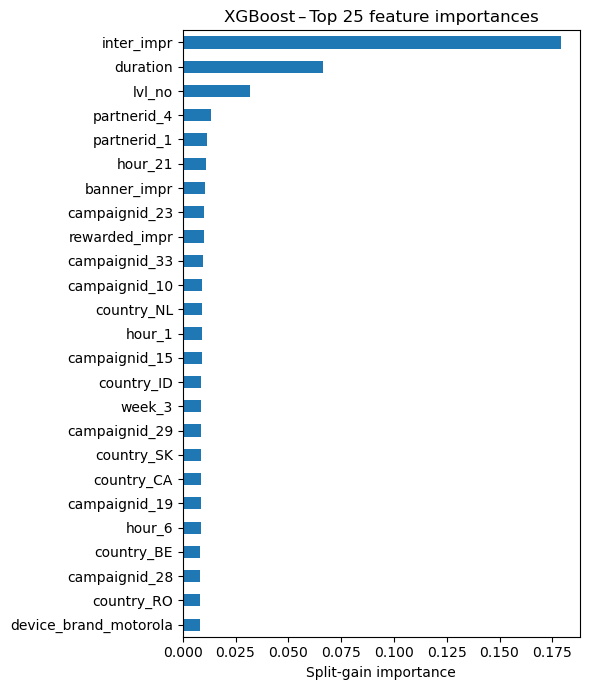


=== Logistic Regression – Top 25 coefficients ===


,coef,abs_coef
lvl_no,-1.679933,1.679933
banner_impr,-0.626174,0.626174
bonus_cnt,0.619268,0.619268
rewarded_impr,-0.395857,0.395857
hint1_cnt,-0.274279,0.274279
inter_impr,0.202118,0.202118
partnerid_1,0.126378,0.126378
partnerid_4,-0.122078,0.122078
campaignid_19,-0.093440,0.093440
duration,-0.090270,0.090270


<Figure size 600x700 with 0 Axes>

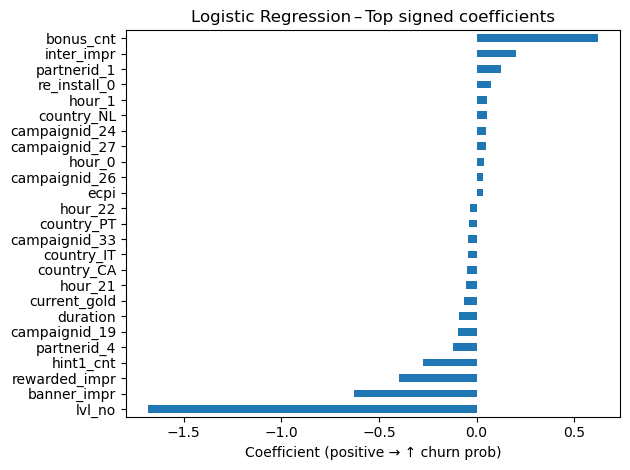

In [81]:
# ------------------------------------------------------------------
# 1.  Prep
# ------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

TOP_N = 25               # how many features to display
FIG_W, FIG_H = 6, 7      # figure size

# ------------------------------------------------------------------
# 2.  Random-Forest feature importance
# ------------------------------------------------------------------
rf_imp = (pd.Series(best_model.feature_importances_,
                    index=X_train_final.columns)
            .sort_values(ascending=False))

print("\n=== Random-Forest – Top {} features ===".format(TOP_N))
display(rf_imp.head(TOP_N).to_frame("Importance"))

plt.figure(figsize=(FIG_W, FIG_H))
rf_imp.head(TOP_N).iloc[::-1].plot(kind="barh")
plt.title("Random Forest – Top {} feature importances".format(TOP_N))
plt.xlabel("Gini importance")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
# 3.  XGBoost feature importance
# ------------------------------------------------------------------
xgb_imp = (pd.Series(xgb_model.feature_importances_,
                     index=X_train_final.columns)
             .sort_values(ascending=False))

print("\n=== XGBoost – Top {} features ===".format(TOP_N))
display(xgb_imp.head(TOP_N).to_frame("Gain"))

plt.figure(figsize=(FIG_W, FIG_H))
xgb_imp.head(TOP_N).iloc[::-1].plot(kind="barh")
plt.title("XGBoost – Top {} feature importances".format(TOP_N))
plt.xlabel("Split-gain importance")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
# 4.  Logistic-Regression coefficients  (signed!)
# ------------------------------------------------------------------
log_reg_full = make_pipeline(
    StandardScaler(with_mean=False),      # sparse matrix friendly
    LogisticRegression(max_iter=2000, n_jobs=-1)
).fit(X_train_final, y_train)

coef = pd.Series(log_reg_full[-1].coef_[0], index=X_train_final.columns)
coef_table = (pd.DataFrame({
                    "coef"    : coef,
                    "abs_coef": coef.abs()
               })
               .sort_values("abs_coef", ascending=False)
               .head(TOP_N))

print("\n=== Logistic Regression – Top {} coefficients ===".format(TOP_N))
display(coef_table)

plt.figure(figsize=(FIG_W, FIG_H))
coef_table.sort_values("coef").plot(
    y="coef", kind="barh", legend=False
)
plt.title("Logistic Regression – Top signed coefficients")
plt.xlabel("Coefficient (positive → ↑ churn prob)")
plt.tight_layout()
plt.show()


# NEW FEATURE

In [83]:
# ------------------------------------------------------------------
# 1.  Revised helper
# ------------------------------------------------------------------
def preprocess_data(df, *, is_train=True, encoder=None):
    """
    Returns
    -------
    X_df      : pd.DataFrame – model-ready features
    encoder   : fitted OneHotEncoder  (returned only when is_train=True)
    """
    df = df.copy()

    # ---------- time features ----------
    df['attribution_event_timestamp'] = pd.to_datetime(df['attribution_event_timestamp'])
    df['week'] = df['attribution_event_timestamp'].dt.isocalendar().week
    df['hour'] = df['attribution_event_timestamp'].dt.hour
    df['day']  = df['attribution_event_timestamp'].dt.dayofweek
    df = df.drop(columns=['attribution_event_timestamp', 'lang'])

    # ---------- new engineered features ----------
    df['lvl_duration_ratio']     = df['lvl_no'] / (df['duration'] + 1)
    df['log_lvl_duration_ratio'] = np.log1p(df['lvl_duration_ratio'])

    # ---------- categorical handling ----------
    cat_cols = ['country', 'device_brand', 're_install',
                'campaignid', 'partnerid', 'week', 'hour', 'day']

    if is_train:
        # group rares → 'other', THEN fit encoder
        for col in cat_cols:
            df[col] = df[col].astype(str)
            rares   = (df[col].value_counts(normalize=True)
                         .loc[lambda s: s < 0.01].index)
            df[col] = df[col].replace(rares, 'other')

        encoder = OneHotEncoder(handle_unknown='ignore',
                                sparse_output=False)
        encoder.fit(df[cat_cols])

    else:
        # map unseen cats → 'other' using encoder.categories_
        for idx, col in enumerate(cat_cols):
            df[col] = df[col].astype(str)
            known   = set(encoder.categories_[idx])
            df[col] = df[col].where(df[col].isin(known), 'other')

    # ---------- one-hot encode ----------
    ohe      = encoder.transform(df[cat_cols])
    ohe_cols = encoder.get_feature_names_out(cat_cols)
    ohe_df   = pd.DataFrame(ohe, columns=ohe_cols, index=df.index)

    # ---------- numeric columns ----------
    num_cols = ['ecpi', 'current_gold', 'totalPowerUp', 'bonus_cnt',
                'duration', 'hint1_cnt', 'lvl_no', 'banner_impr',
                'inter_impr', 'rewarded_impr',
                'lvl_duration_ratio', 'log_lvl_duration_ratio']

    X_df = pd.concat([df[num_cols].reset_index(drop=True),
                      ohe_df.reset_index(drop=True)], axis=1)

    return (X_df, encoder) if is_train else (X_df, None)


# ------------------------------------------------------------------
# 2.  Build train + test matrices
# ------------------------------------------------------------------
X_train_full, encoder = preprocess_data(df, is_train=True)
y_train_full          = df['churn']

X_test_proc, _        = preprocess_data(test_df, is_train=False, encoder=encoder)

# guarantee identical column order (in case the fit order ever changes)
X_test_proc = X_test_proc.reindex(columns=X_train_full.columns, fill_value=0)


# ------------------------------------------------------------------
# 3.  Fit the tuned Random-Forest
# ------------------------------------------------------------------
best_model = RandomForestClassifier(
    n_estimators     = 200,
    max_depth        = 12,
    min_samples_leaf = 5,
    class_weight     = 'balanced',
    random_state     = 42
).fit(X_train_full, y_train_full)


# ------------------------------------------------------------------
# 4.  Feature importance + prediction
# ------------------------------------------------------------------
importances = (pd.Series(best_model.feature_importances_,
                         index=X_train_full.columns)
                 .sort_values(ascending=False))

print("\nTop 10 features:\n", importances.head(10))

test_df['churn'] = best_model.predict(X_test_proc)
test_df[['test_id', 'churn']].to_csv('predictions_with_new_feats.csv', index=False)
print("✓ New predictions saved to predictions_with_new_feats.csv")



Top 10 features:
 inter_impr                0.148975
lvl_no                    0.148120
duration                  0.132121
banner_impr               0.112467
lvl_duration_ratio        0.086510
log_lvl_duration_ratio    0.080682
bonus_cnt                 0.073746
hint1_cnt                 0.046696
rewarded_impr             0.044342
current_gold              0.034803
dtype: float64
✓ New predictions saved to predictions_with_new_feats.csv


In [84]:
# ------------------------------------------------------------------
# Cross-validated performance of the new feature set
# ------------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_metrics = {
    "fold": [], "accuracy": [], "precision": [], "recall": [],
    "specificity": [], "f1": [], "roc_auc": []
}

for fold, (idx_tr, idx_val) in enumerate(cv.split(X_train_full, y_train_full), 1):
    X_tr, X_val = X_train_full.iloc[idx_tr], X_train_full.iloc[idx_val]
    y_tr, y_val = y_train_full.iloc[idx_tr], y_train_full.iloc[idx_val]

    # fresh clone each fold
    clf = RandomForestClassifier(
        n_estimators     = 200,
        max_depth        = 12,
        min_samples_leaf = 5,
        class_weight     = 'balanced',
        random_state     = 42
    ).fit(X_tr, y_tr)

    y_pred = clf.predict(X_val)
    y_prob = clf.predict_proba(X_val)[:, 1]

    cm  = confusion_matrix(y_val, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fold_metrics["fold"].append(fold)
    fold_metrics["accuracy"].append(accuracy_score(y_val, y_pred))
    fold_metrics["precision"].append(precision_score(y_val, y_pred))
    fold_metrics["recall"].append(recall_score(y_val, y_pred))
    fold_metrics["specificity"].append(tn / (tn + fp))
    fold_metrics["f1"].append(f1_score(y_val, y_pred))
    fold_metrics["roc_auc"].append(roc_auc_score(y_val, y_prob))

# ------------------------------------------------------------------
# Pretty summary
# ------------------------------------------------------------------
cv_summary = pd.DataFrame(fold_metrics)
means = cv_summary.mean(numeric_only=True).rename("mean").to_frame().T
print("\n=== 5-Fold CV – per-fold metrics ===")
display(cv_summary.round(4))

print("\n=== 5-Fold CV – averaged ===")
display(means.round(4))



=== 5-Fold CV – per-fold metrics ===


,fold,accuracy,precision,recall,specificity,f1,roc_auc
0,1,0.8102,0.9268,0.8270,0.7446,0.8741,0.8714
1,2,0.8102,0.9256,0.8282,0.7397,0.8742,0.8712
2,3,0.8101,0.9245,0.8292,0.7353,0.8743,0.8704
3,4,0.8136,0.9254,0.8331,0.7372,0.8768,0.8753
4,5,0.8120,0.9233,0.8331,0.7292,0.8759,0.8734



=== 5-Fold CV – averaged ===


,fold,accuracy,precision,recall,specificity,f1,roc_auc
mean,3.0,0.8112,0.9251,0.8301,0.7372,0.8751,0.8723
